# Burgers' Equation PINN Implementation

This notebook demonstrates the implementation of a Physics-Informed Neural Network (PINN) for solving the Burgers' equation using DeepXDE (the code and further documentation can be found online at https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html).

In [1]:
import torch
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Matplotlib is building the font cache; this may take a moment.


## Test Data Generation
Function to load and prepare test data from the Burgers dataset.

In [ ]:
def gen_testdata():
    data = np.load("../dataset/Burgers.npz") # Change to the downloaded dataset path
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

## PDE Definition
Define the Burgers' equation PDE for the PINN model.

In [3]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

## Geometry and Domain Definition
Define the spatial and temporal domains for the problem.

In [4]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Boundary and Initial Conditions
Define the boundary and initial conditions for the problem.

In [5]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

## Model Setup and Training
Set up the PINN model and train it using Adam and L-BFGS optimizers.

Compiling model...
'compile' took 2.431363 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.16e-03, 4.66e-02, 6.76e-01]    [9.16e-03, 4.66e-02, 6.76e-01]    []  
1000      [4.04e-02, 5.66e-04, 5.55e-02]    [4.04e-02, 5.66e-04, 5.55e-02]    []  

Best model at step 1000:
  train loss: 9.65e-02
  test loss: 9.65e-02
  test metric: []

'train' took 3.947958 s

Compiling model...
'compile' took 0.000293 s

Training model...

Step      Train loss                        Test loss                         Test metric
1000      [4.04e-02, 5.66e-04, 5.55e-02]    [4.04e-02, 5.66e-04, 5.55e-02]    []  
2000      [2.89e-03, 1.45e-05, 9.85e-04]    [2.89e-03, 1.45e-05, 9.85e-04]    []  
3000      [2.76e-04, 8.60e-07, 6.65e-05]    [2.76e-04, 8.60e-07, 6.65e-05]    []  
4000      [9.73e-05, 2.30e-07, 3.02e-05]    [9.73e-05, 2.30e-07, 3.02e-05]    []  
5000      [5.61e-05, 2.41e-07, 1.84e-05]    [5.61e-05, 2.41e-07, 1.84e-05]   

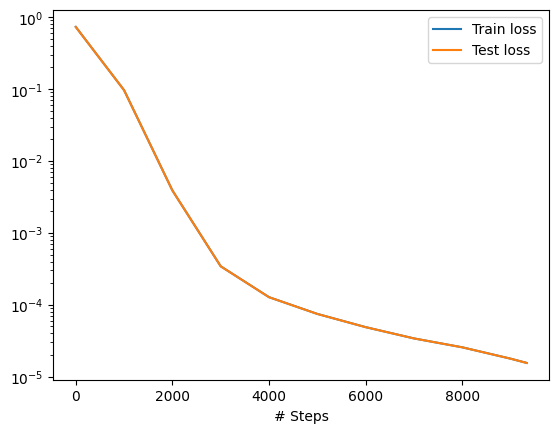

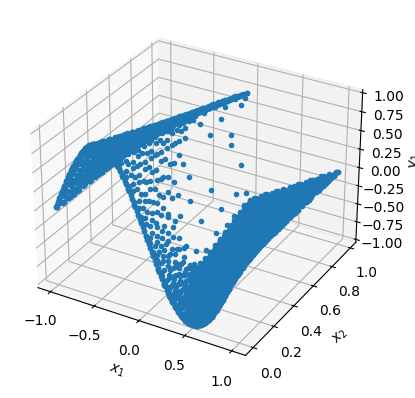

In [6]:
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=1000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)